<a href="https://colab.research.google.com/github/dpiponi/colabs/blob/main/Inverse_Radon_transform_using_Tensorflow_derivative_adjoint_trick.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from PIL import Image
from io import BytesIO
import numpy as np
import requests
import matplotlib.pyplot as plt

Pull a suitable image down from the web

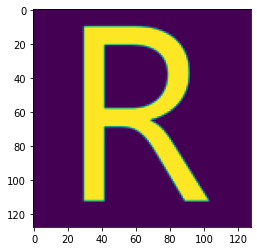

In [ ]:
img_data = requests.get("https://iconsplace.com/wp-content/uploads/_icons/000000/256/png/letter-r-icon-256.png")
data = tf.cast(tf.reduce_mean(np.array(Image.open(BytesIO(img_data.content)).resize((128, 128))), axis=-1), tf.float32)
plt.imshow(data)

We do tomography by projecting the image along different angles. Here 'projecting' means 'squashing down' the image by integrating along the direction of squashing. So for each of `n_angles` angles we have `n_rays` rays at that angle and we sum `n_samples` samples along those rays in the image. This link illustrates this nicely:

https://twitter.com/kolibril13/status/1430249252199018496?s=20

To that end we build a 3-D array of all points along all rays at all angles.

In [ ]:
n_angles = 100
n_rays = 104
n_samples = 108
rays = tf.linspace(-1., 1., n_rays)
samples = tf.linspace(-1., 1., n_samples)
angles = tf.linspace(0., 2 * 3.14159, n_angles)[:-1]
[x, y, theta] = tf.meshgrid(samples, rays, angles, indexing='ij')
coords = tf.stack([
  x * tf.cos(theta) - y * tf.sin(theta),
  x * tf.sin(theta) + y * tf.cos(theta)], axis=-1)

Some examples of lines that we'll be summing along

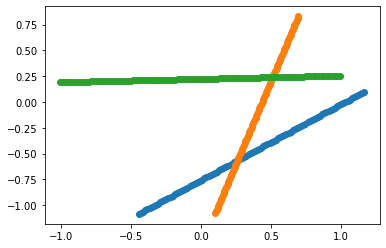

In [ ]:
plt.scatter(coords[:, 20, 10, 0], coords[:, 20, 10, 1])
plt.scatter(coords[:, 30, 20, 0], coords[:, 30, 20, 1])
plt.scatter(coords[:, 40, 50, 0], coords[:, 40, 50, 1])

Now do some tomography.

Integrate along the rays using `reduce_sum`, interpolating the image for smoother results.

Each vertical column in this image is one projection. This has the fancy name "Radon transform" but it's really just the sum of the image along lots of lines.

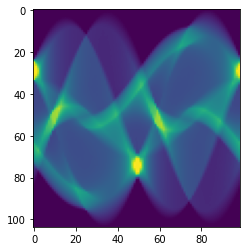

In [ ]:
expected_images = tf.reduce_sum(
    tfp.math.batch_interp_regular_nd_grid(coords, [-1., -1.], [1., 1.], data, axis=-2),
    axis=0)
plt.imshow(expected_images)

Here's an example of one vertical slice

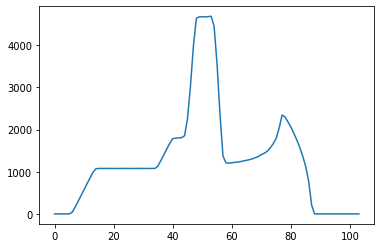

In [ ]:
plt.plot(expected_images[:, 10])

Now suppose we don't have the original image, just `expected_images`. We want to invert this to recover the original. We can cast this as a standard machine learning-type problem by saying we want to find the image whose Radon transform is as close as possible, in the least-squares sense, to what we've been given. So we start with the zero image and do one step of gradient descent.

We're solving this problem: given $y$, find $x$ to minimize $e(x) = \frac{1}{2}||y-Rx||^2$ where $R$ is the Radon transform. The gradient is $de/dx = R^T(y-Rx)$. We're evaluating this at the zero image $x=0$ so we're actually computing $R^Ty$. So automatic differentiation is giving us the adjoint of the Radon transform. Using the adjoint is a well known way to approximately invert the Radon transform and the technique is called back-projection. This derivation shows it's in fact back-propagation in disguise.

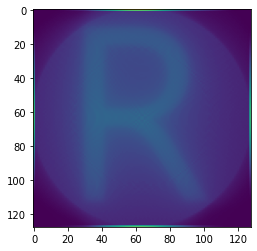

In [ ]:
zero_image = tf.Variable(tf.zeros(data.shape))
with tf.GradientTape() as tape:
  images = tf.reduce_sum(
      tfp.math.batch_interp_regular_nd_grid(coords, [-1., -1.], [1., 1.], zero_image, axis=-2),
      axis=0)
  error = tf.reduce_sum(tf.math.squared_difference(expected_images, images))

grad = tape.gradient(error, zero_image)

# Show the result of taking one step down the gradient
plt.imshow(-grad)